In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

# parameters
n_loans = 5000
loan_ids = [f"L{i:05d}" for i in range(n_loans)]

# origination dates between 2020 and 2025
orig_dates = pd.to_datetime(
    np.random.choice(pd.date_range("2020-01-01", "2025-01-01", freq="W"), size=n_loans)
)

# choose factor date after origination (loan age in months)
ages = np.random.randint(1, 60, size=n_loans)
factor_dates = orig_dates + pd.to_timedelta(ages * 30, unit="D")

# loan purpose
purposes = np.random.choice(["Refi", "Cashout"], size=n_loans, p=[0.6, 0.4])

# CLTV: tighter for refi, higher for cashout
cltv = np.random.uniform(20, 80, size=n_loans)

# rate incentive (negative means below market)
rate_incentive = np.random.uniform(-2, 2, n_loans)

# balance
balances = np.random.uniform(5000, 500000, n_loans)

# prepayment rate dynamic — driven by incentive, age, and cltv
base_prepay = 0.05 + 0.02 * np.random.randn(n_loans)
prepay_rate = (
    base_prepay
    + 0.10 * rate_incentive * 10  # more incentive → higher prepay
    + 0.02 * (100 - cltv)         # lower cltv → more mobility
    + 0.05 * ages             # seasoning effect
)

# rescale the prepayment rates to be between 0 to 5% based on prepay_rate
prepay_rate = (prepay_rate - prepay_rate.min()) / (prepay_rate.max() - prepay_rate.min()) * 0.05

# assemble
df = pd.DataFrame({
    "loan_id": loan_ids,
    "origination_date": orig_dates,
    "factor_date": factor_dates,
    "age": ages,
    "loan_purpose": purposes,
    "cltv": cltv.round(3),
    "incentive": rate_incentive.round(3),
    "balance": balances.round(2),
    "prepay_rate": prepay_rate.round(4),
    "model_pred" : np.random.uniform(0, 0.05, n_loans).round(4)
})

# derived realism — ensure factor_date <= 2025-12-31
df = df[df["factor_date"] <= "2025-12-31"].reset_index(drop=True)

print(df.head())


  loan_id origination_date factor_date  age loan_purpose    cltv  incentive  \
0  L00001       2022-01-16  2022-09-13    8         Refi  52.354     -1.676   
1  L00002       2021-05-16  2023-10-03   29      Cashout  67.626      1.657   
2  L00004       2020-05-24  2022-09-11   28      Cashout  56.197     -0.208   
3  L00005       2021-12-19  2022-06-17    6      Cashout  60.134      1.893   
4  L00006       2022-05-01  2023-08-24   16         Refi  59.301      1.962   

     balance  prepay_rate  model_pred  
0   62621.80       0.0071      0.0050  
1  231165.04       0.0326      0.0399  
2  259733.33       0.0220      0.0189  
3  372231.67       0.0278      0.0354  
4  343054.21       0.0315      0.0465  


In [2]:
from quantbullet.linear_product_model.mtg_perf_eval import MtgModelPerformanceEvaluator, MtgPerfColnames

In [3]:
colnames = MtgPerfColnames(
    incentive='incentive',
    dt='factor_date',
    orig_dt='origination_date',
    response='prepay_rate',
    model_preds={
        'Model' : 'model_pred'
    },
    weighted_by='balance'
)

In [4]:
# add some large numbers to vintage 2023 for testing
df.loc[df['origination_date'].dt.year == 2023, 'balance'] += 10e6

In [5]:
evaluator = MtgModelPerformanceEvaluator(
    df = df,
    colname_mapping=colnames
)

(<Figure size 1500x800 with 6 Axes>,
 array([<Axes: title={'center': 'Vintage 2020'}>,
        <Axes: title={'center': 'Vintage 2021'}>,
        <Axes: title={'center': 'Vintage 2022'}>,
        <Axes: title={'center': 'Vintage 2023'}>,
        <Axes: title={'center': 'Vintage 2024'}>, <Axes: >], dtype=object))

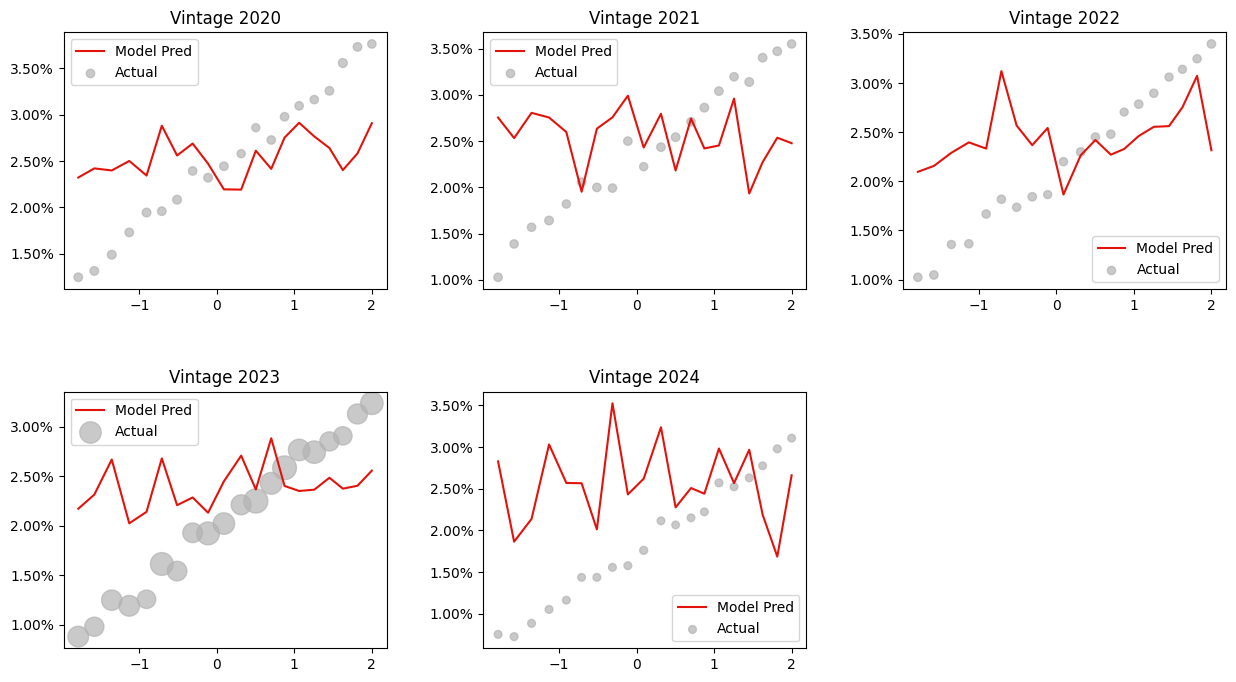

In [6]:
evaluator.incentive_by_vintage_year_plots( n_quantile_bins=20, n_cols=3, scatter_size_by='sum_weights', scatter_size_scale=0.3 )

In [8]:
import numpy as np
import quantbullet as qb
import matplotlib.pyplot as plt

In [9]:
smodel = qb.parametric_model.SplineModel()

In [10]:
smodel.fit( x = [1, 12, 24, 36, 48, 60], y = [1, 1.2, 1.4, 1.1, 0.8, 0.6] )

SplineModel({'t': [1.0, 24.0, 36.0, 60.0], 'c': [1.0, 0.9957783408299241, 1.6733123819350135, 0.917313289786794, 0.7163433551066032, 0.6], 'k': 3})

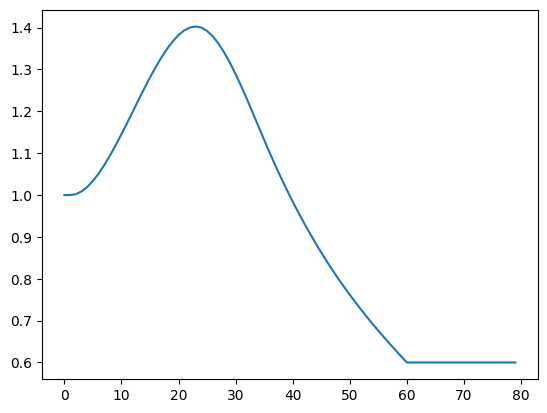

In [11]:
x = np.arange(0, 80, 1)
y = smodel.predict( x )
plt.plot( x, y )